In [347]:
# взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
# сделать обзорный анализ выбранного датасета
# сделать feature engineering
# обучить любой классификатор (какой вам нравится)
# разобраться с SHAP и построить важности признаков для:
# всего тестового набора данных (summary_plot - дать интерпретацию)
# для топ 10%
# для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат
# https://habr.com/ru/company/otus/blog/465329/ про snap
# https://vk.com/@karpovcourses-interpretaciya-modelei-mashinnogo-obucheniya-v-python-shap про snap

In [348]:
import pandas as pd
import numpy as np
import re
# !pip install shap
import shap
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, log_loss
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import random
import warnings
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)
random.seed(42)

In [349]:
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML в бизнесе/bank.csv', sep=';')

In [350]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [351]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [352]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [353]:
X = data.copy().drop(['y'], axis=1)
y = data['y']

In [354]:
y.value_counts()

no     4000
yes     521
Name: y, dtype: int64

In [355]:
for i in X.columns:
  print(f'{i.upper()}\n\n{X[i].value_counts()}\n{50*"*"}\n\n')

AGE

34    231
32    224
31    199
36    188
33    186
     ... 
76      2
84      1
81      1
86      1
87      1
Name: age, Length: 67, dtype: int64
**************************************************


JOB

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64
**************************************************


MARITAL

married     2797
single      1196
divorced     528
Name: marital, dtype: int64
**************************************************


EDUCATION

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64
**************************************************


DEFAULT

no     4445
yes      76
Name: default, dtype: int64
**************************************************


BALANCE

0       357
2        24
1       

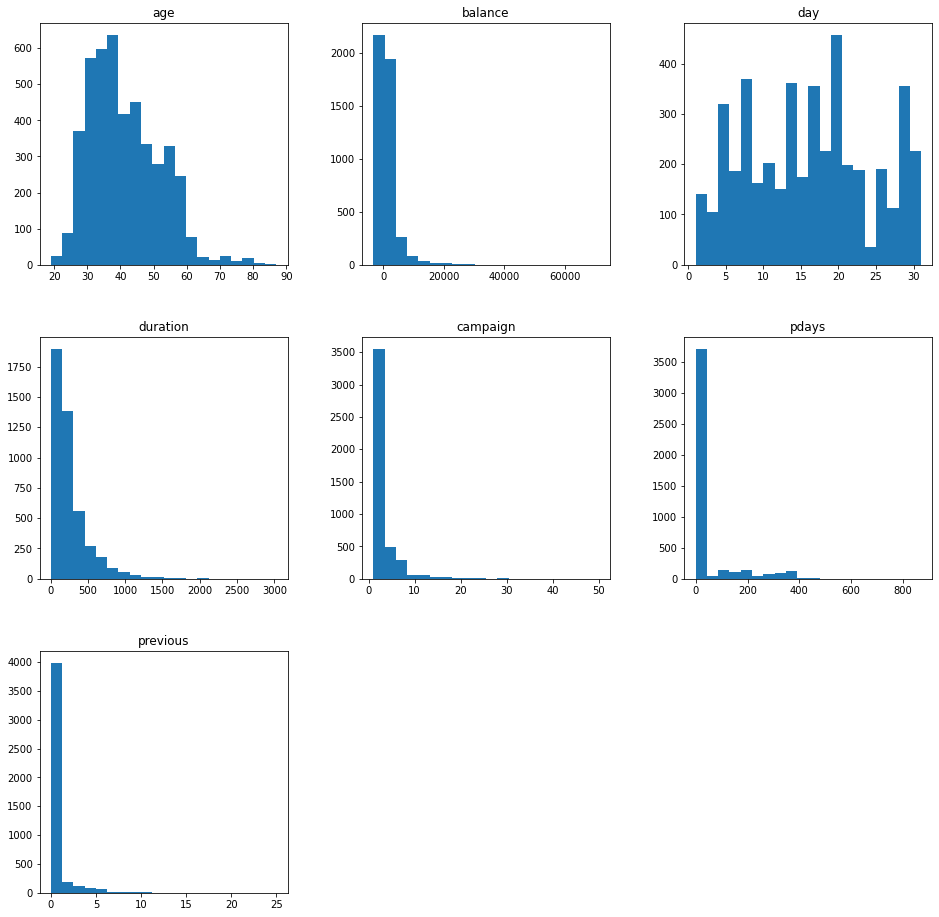

In [356]:
X_num_features = X.select_dtypes(include=['float64', 'int64'])
X_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [357]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [358]:
# Функция для разделения категориальных и числовых признаков
def split_features(data):
  cat_feats = []
  num_feats = []

  for i in range(len(data.columns)):
    if type(data[data.columns[i]][0]) == str:
      cat_feats.append(data.columns[i])
    else:
      num_feats.append(data.columns[i])

  return cat_feats, num_feats

In [359]:
# Функция для формирования списка названий трансформированных признаков
def get_features_transformed(model):

    features_transformed = []

    for i in range(len(model[0].transformer_list)):
        if model[0].transformer_list[i][0] in cat_feats:
            temp = model.named_steps['feats'].transformer_list[i][1].named_steps['ohe'].columns
            [features_transformed.append(i) for i in temp]
        else:
            features_transformed.append(model[0].transformer_list[i][1][0].key)
    return features_transformed

In [360]:
# table_comp = pd.DataFrame({'Model': [],
#                            'Threshold': [],
#                            'F-Score': [],
#                            'Precision': [],
#                            'Recall': [],
#                            'ROC AUC': [],
#                            'TP': [],
#                            'FP': [],
#                            'TN': [],
#                            'FN': []})

In [361]:
cat_feats, num_feats = split_features(X)

In [362]:
num_feats

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [363]:
# Отберем признаки, в которых есть ответы только 'yes' и 'no'
feats_y_n = []
for i in cat_feats:
  if X[i][0] == 'yes' or X[i][0] == 'no':
    feats_y_n.append(i)
feats_y_n

['default', 'housing', 'loan']

In [364]:
for i in feats_y_n:
  if i in cat_feats:
    cat_feats.remove(i)
cat_feats

['job', 'marital', 'education', 'contact', 'month', 'poutcome']

In [365]:
# Заменяем значения 'yes' и 'no' на 1 и 0
for y_n_col in feats_y_n:
  X.replace({y_n_col: {'yes': 1, 'no': 0}}, inplace=True)

# Заменяем значения 'yes' и 'no' на 1 и 0 в таргете
y.replace({'yes': 1, 'no': 0}, inplace=True)
y.value_counts()

0    4000
1     521
Name: y, dtype: int64

In [366]:
# Набор трансформеров для признаков
final_transformers = list()

# Делаем dummy признаки из категориальных
for cat_col in cat_feats:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)), 
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

# Проведем стандартизацию признаков
for col in num_feats:
    st_transformer = Pipeline([
                ('selector', NumberSelector(key=col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((col, st_transformer))

# Отберем оставшиеся признаки
for col_y_n in feats_y_n:
    non_transformer = Pipeline([
                ('selector', NumberSelector(key=col_y_n))
            ])
    final_transformers.append((col_y_n, non_transformer))
    

feats_final = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats_final)])

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.3)

In [368]:
# Вытащим названия трансформированных признаков
feature_processing.fit(X_train)
feats_trans_names = get_features_transformed(feature_processing)

In [369]:
pipeline = Pipeline([
    ('features', feats_final),
    ('classifier', xgb.XGBClassifier()),
])

pipeline = pipeline.fit(X_train, y_train)
preds_rf = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_rf)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

# cnf_matrix = confusion_matrix(y_test, preds_rf>thresholds[ix])
# table_comp.loc[0] = ['XGBClassifier', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds_rf), cnf_matrix[1][1], cnf_matrix[0][1], cnf_matrix[0][0], cnf_matrix[1][0]]

Best Threshold=0.237033, F-Score=0.535, Precision=0.474, Recall=0.613


### **SHAP for X_train**

In [370]:
# Датасет после трансформации
X_train_trans = pd.DataFrame(feature_processing.transform(X_train), columns=feats_trans_names)
X_train_trans.head(3)

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous,default,housing,loan
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.514800,-0.582399,0.193798,1.269357,0.329842,3.060364,2.138396,0.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.444566,-0.367042,0.437913,0.105114,-0.548873,0.548974,2.138396,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.301859,-0.460245,-1.270893,1.292110,0.036937,-0.395391,-0.328354,0.0,1.0,0.0


In [371]:
# SNAP
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(feature_processing.transform(X_train))

In [372]:
shap.initjs() # Для решения ошибки визуализации в Colab
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_trans.iloc[0,:])

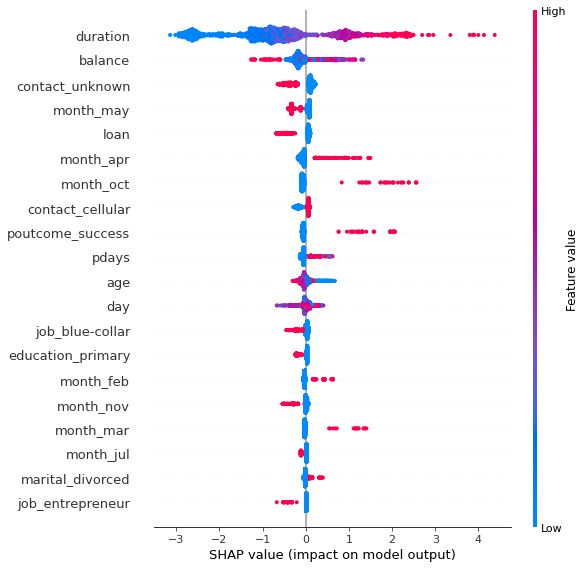

In [373]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train_trans)

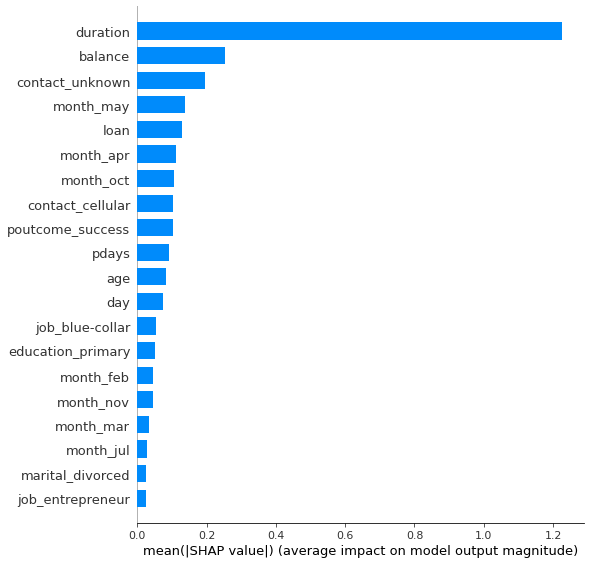

In [374]:
shap.summary_plot(shap_values, X_train_trans, plot_type="bar")

### **SHAP for X_test**

**1. Для всей выборки.**

In [375]:
# Датасет после трансформации
X_test_trans = pd.DataFrame(feature_processing.transform(X_test), columns=feats_trans_names)

In [376]:
explainer_test = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values_test = explainer.shap_values(feature_processing.transform(X_test))

In [377]:
shap.initjs() # Для решения ошибки визуализации в Colab
shap.force_plot(explainer.expected_value, shap_values_test[0,:], X_test_trans.iloc[0,:])

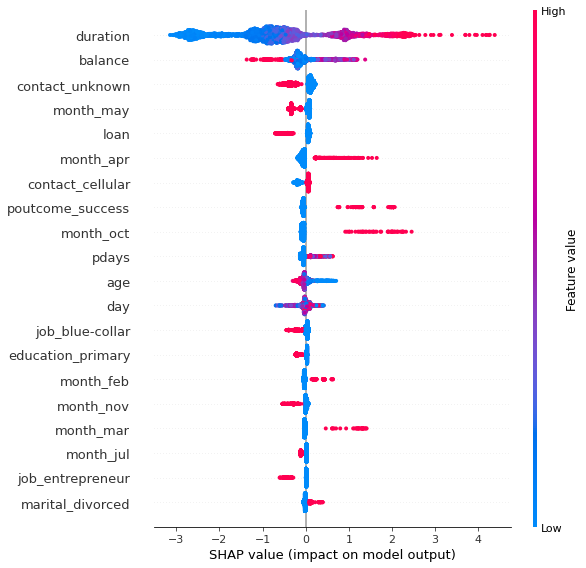

In [378]:
shap.summary_plot(shap_values_test, X_test_trans)

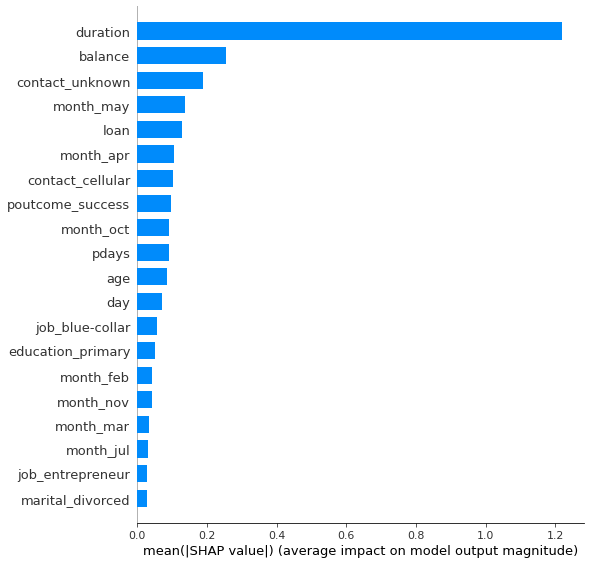

In [379]:
shap.summary_plot(shap_values_test, X_test_trans, plot_type="bar")

**Вывод:** Топ-5 важных признаков:
* duration
* balance
* contact_unknown
* month_may
* loan


**2. Для топ 10% данных по значениям вероятностей.**

In [380]:
# Отберем топ 10% примеров по вероятностям предсказаний
best_n = np.argsort(preds_rf)[-round(len(preds_rf)*0.1):]
X_test_trans_10 = X_test_trans.loc[best_n]

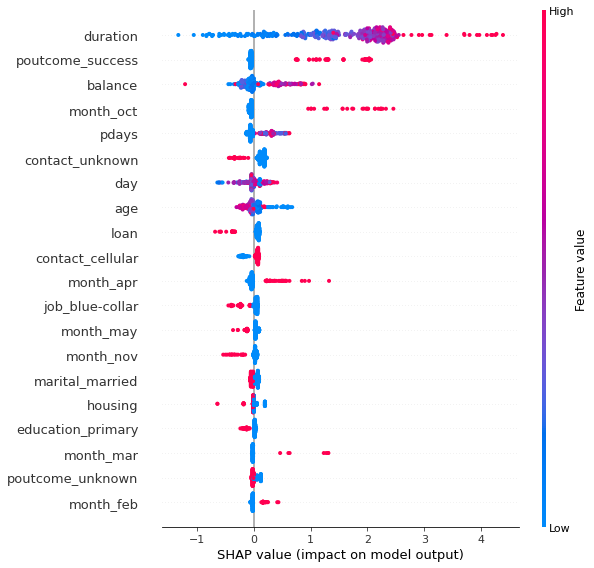

In [381]:
shap.summary_plot(shap_values_test[best_n], X_test_trans_10)

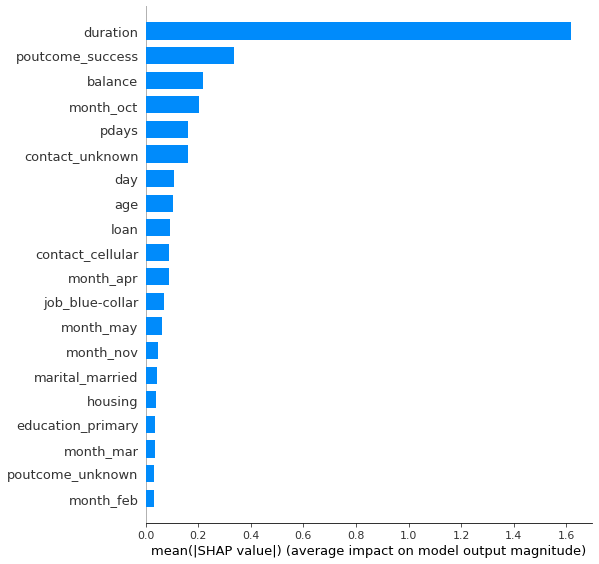

In [382]:
shap.summary_plot(shap_values_test[best_n], X_test_trans_10, plot_type="bar")

**Вывод:** Топ-5 важных признаков изменился:
* duration
* poutcome_success
* balance
* month_oct
* pdays


**3. Для отдельных наблюдений.**

In [383]:
# Найдем аномальный показатель из summary_plot по признаку balance
for i in shap_values_test[2]:
  if i < -1:
    straing_feat = list(shap_values_test[2]).index(i)
    print(straing_feat)

41


In [384]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_test[straing_feat,:], X_test_trans_10.iloc[straing_feat,:])

**Вывод:** Мы выбрали объект под индексом $41$, у которого аномальное по сравнению с другими объектами поведение признака **balance** (см. график **summary_plot**). При высоких значениях вероятность отнесения объекта к классу $1$ должна повышаться, но у него она снижается. Как видно из детального графика **force_plot**, ключевую роль в занижении вероятности играет признак **duration** (*last contact duration, in seconds (numeric)*). Можно интерпритировать результат, как то, что разговор с оператором не убедил владельца с большим балансом сделать срочный вклад. Далее можно выяснить, было ли это дело в манере разговора оператора, либо - это выброс и просто такой несговорчивый клиент.